In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.labels = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.images = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 28, 28) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


In [13]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 28, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


In [14]:
train_dataset = SignLanguageDataset('../../data/sign_mnist_train.csv')
test_dataset = SignLanguageDataset('../../data/sign_mnist_test.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 26
num_epochs = 10
learning_rate = 0.001

model = RNNModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculer la précision sur le jeu d'entraînement
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
    
    # Calculer la précision sur le jeu de test
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/10], Loss: 0.6129, Train Accuracy: 85.19%, Test Accuracy: 73.02%
Epoch [2/10], Loss: 0.0992, Train Accuracy: 97.87%, Test Accuracy: 78.17%
Epoch [3/10], Loss: 0.0658, Train Accuracy: 99.31%, Test Accuracy: 78.67%
Epoch [4/10], Loss: 0.0020, Train Accuracy: 100.00%, Test Accuracy: 82.31%
Epoch [5/10], Loss: 0.0013, Train Accuracy: 100.00%, Test Accuracy: 82.43%
Epoch [6/10], Loss: 0.0013, Train Accuracy: 100.00%, Test Accuracy: 82.92%
Epoch [7/10], Loss: 0.0012, Train Accuracy: 100.00%, Test Accuracy: 83.31%
Epoch [8/10], Loss: 0.0005, Train Accuracy: 100.00%, Test Accuracy: 83.18%
Epoch [9/10], Loss: 0.0005, Train Accuracy: 100.00%, Test Accuracy: 83.56%
Epoch [10/10], Loss: 0.0003, Train Accuracy: 100.00%, Test Accuracy: 83.71%


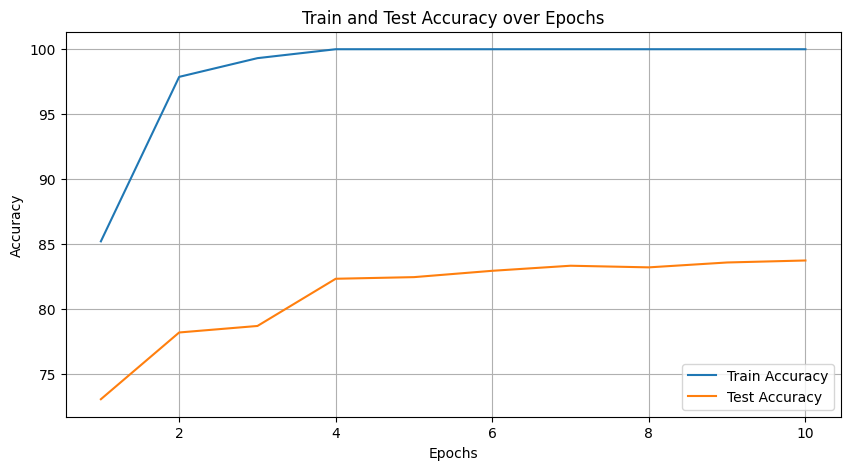

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


In [17]:
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0002
Epoch [2/10], Loss: 0.0002
Epoch [3/10], Loss: 0.0002
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 2.6674
Epoch [7/10], Loss: 0.6993
Epoch [8/10], Loss: 0.4684
Epoch [9/10], Loss: 0.1349
Epoch [10/10], Loss: 0.0663


Accuracy of the model on the test images: 85.49%


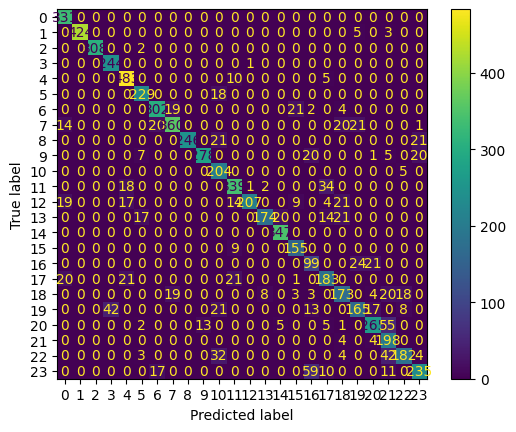

In [19]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Générer les graphiques de matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

